In [101]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def load_cmc_data(start_date, end_date, first=150): 
    """
    load snapshots between start_date and end_date
    returns defaultdict {date: data,}
    """

    start_dt = datetime.strptime(start_date, '%Y%m%d')
    end_dt = datetime.strptime(end_date, '%Y%m%d')
    delta = end_dt - start_dt
    
    cmc = {}
    for dt in range(delta.days+1):
        snapshot = datetime.strftime(start_dt + timedelta(days=dt),'%Y%m%d')
        cmc[snapshot] = pd.read_csv(f'./cmc_snapshots/cmc_snapshot_{snapshot}.csv').iloc[:first]
        if len(cmc[snapshot]) != first:
            print(f'Problem in loaded {snapshot} - of length {len(cmc[snapshot])}') # check for data integrity; make sure there are N rows
    
    return cmc


coin_data = load_cmc_data('20150101', '20201129')
print('loaded cmc data')


loaded cmc data


# Single coin data

In [136]:
for sym in ['btc','eth']:
    df = pd.DataFrame(columns = ['date','price'])
    for dt, data in coin_data.items():
        try:
            price = data[data['symbol']==sym.upper()]['price'].to_list()[0]
        except:
            price = None
        df = df.append({'date':dt, 'price':price}, ignore_index=True)
    df = df.sort_values('date')
    df = df[~df['price'].isna()]
    df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y%m%d'))
    df = df.set_index('date')
    dfg = df.resample('3D').apply(lambda x : x.iloc[-1])
    dfg = dfg.sort_index()
    dfg['ret'] = dfg['price']/dfg['price'].shift(1)
    dfg['logret'] = dfg['ret'].apply(lambda x: np.log(x))
    for t in range(1,4):
        dfg[f'logret_lag{t}'] = dfg['logret'].shift(t)
    dfg = dfg.dropna(how='any')
    dfg.to_csv(f'./data/{sym}.csv', index=True)
    print(f'saved data for {sym.upper()}')

saved data for BTC
saved data for ETH


# Multivariate data

In [249]:
# MULTIVARIATE

symbols = ['btc','eth','xrp','ltc','link']

df = pd.DataFrame(columns = ['date'] + [f'{s}_price' for s in symbols])
for dt, data in coin_data.items():
    temp = {'date':dt}
    for s in symbols:
        try:
            price = data[data['symbol']==s.upper()]['price'].to_list()[0]
        except:
            price = None
        temp.update({f'{s}_price':price})
    df = df.append(temp, ignore_index=True)

df = df.sort_values('date')
for s in symbols:
    df = df[~df[f'{s}_price'].isna()]

print(df.head())

df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y%m%d'))
df = df.set_index('date')

dfg = df.resample('3D').apply(lambda x : x.iloc[-1])
dfg = dfg.sort_index()

print(dfg.head())

for s in symbols:
    dfg[f'{s}_ret'] = dfg[f'{s}_price']/dfg[f'{s}_price'].shift(1)
    dfg[f'{s}_logret'] = dfg[f'{s}_ret'].apply(lambda x: np.log(x))
    # for t in range(1,4):
    #     dfg[f'logret_lag{t}'] = dfg['logret'].shift(t)
    print(dfg.head())
    dfg = dfg.dropna(how='any') # this should not be indented
dfg.to_csv(f'./data/5coins.csv', index=True)
print(f'saved data.')

         date  btc_price eth_price  xrp_price  ltc_price link_price
993  20170920    3905.95    283.74   0.182078      51.73   0.189165
994  20170921    3631.04    258.58   0.171754      46.61    0.16968
995  20170922    3630.70    264.31   0.173510      48.09   0.150503
996  20170923    3792.40    286.17   0.177882      49.27   0.131129
997  20170924    3682.84    282.48   0.175787      47.62   0.170278
            btc_price  eth_price  xrp_price  ltc_price  link_price
date                                                              
2017-09-20    3630.70     264.31   0.173510      48.09    0.150503
2017-09-23    3926.07     292.33   0.181487      51.58    0.182198
2017-09-26    4174.73     299.16   0.196131      54.09    0.243795
2017-09-29    4403.74     302.34   0.206532      54.54    0.436647
2017-10-02    4229.36     292.66   0.214774      51.40    0.397361
            btc_price  eth_price  xrp_price  ltc_price  link_price   btc_ret  \
date                                       

In [245]:
# MULTIVARIATE

symbols = ['btc','eth','xrp','ltc','link']

df = pd.DataFrame(columns = ['date'] + [f'{s}_price' for s in symbols])
for dt, data in coin_data.items():
    temp = {'date':dt}
    for s in symbols:
        try:
            price = data[data['symbol']==s.upper()]['price'].to_list()[0]
        except:
            price = None
        temp.update({f'{s}_price':price})
    df = df.append(temp, ignore_index=True)

df = df.sort_values('date')
for s in symbols:
    df = df[~df[f'{s}_price'].isna()]

df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y%m%d'))
df = df.set_index('date')

# dfg = df.resample('3D').apply(lambda x : x.iloc[-1])
df = df.sort_index()

# for s in symbols:
#     dfg[f'{s}_ret'] = dfg[f'{s}_price']/dfg[f'{s}_price'].shift(1)
#     dfg[f'{s}_logret'] = dfg[f'{s}_ret'].apply(lambda x: np.log(x))
#     # for t in range(1,4):
#     #     dfg[f'logret_lag{t}'] = dfg['logret'].shift(t)
#     dfg = dfg.dropna(how='any')
df.to_csv(f'./data/coins_data.csv', index=True)
print(f'saved data.')

saved data.


# Univariate fit

In [53]:
stat = pd.read_csv('./stat.csv')
stat['date'] = stat['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

def state_map(s):
    # steady market
    if s == 1:
        return 1
    # growth market
    if s == 2:
        return 1
    # bearish market
    if s == 3:
        return -1
    # bullish volatile market
    if s == 4:
        return 1

stat['decision'] = stat['state'].apply(state_map)
stat['decision_lag1'] = stat['decision'].shift(1)
stat['payoff'] = stat['logret'] * stat['decision_lag1']
stat['payoff_cum'] = stat['payoff'].cumsum()

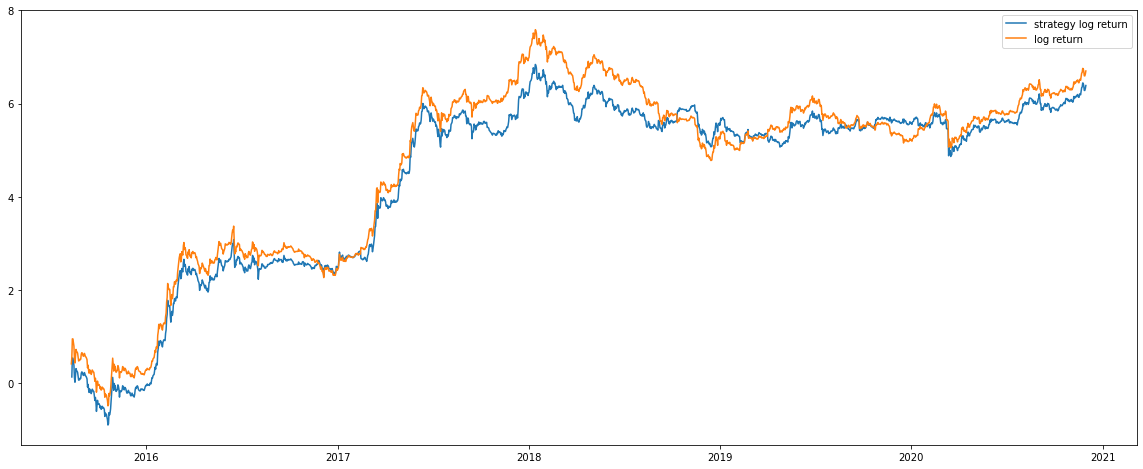

In [54]:
import matplotlib.pyplot as plt
import math

plt.rcParams["figure.figsize"] = (20,8)

plt.plot(stat['date'],stat['payoff_cum'], label='strategy log return')
# plt.plot(stat['date'],stat['logret'].apply(lambda x: (math.e)**x).cumprod(), label='BAH simple return')
plt.plot(stat['date'],stat['logret'].cumsum(), label='log return')
plt.legend()
plt.show()

# Multivariate fit

In [243]:
# MULTIVARIATE

symbols = ['btc','eth','xrp']
N = 3

stat = pd.read_csv('./stat.csv')
stat['date'] = stat['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))


def btc_state_map(s):
    if s == 1:
        return 1
    if s == 2:
        return 1
    if s == 3:
        return -1
    if s == 4:
        return 1

def eth_state_map(s):
    if s == 1:
        return 1
    if s == 2:
        return 1
    if s == 3:
        return -1
    if s == 4:
        return 1

def xrp_state_map(s):
    if s == 1:
        return 1
    if s == 2:
        return 1
    if s == 3:
        return -1
    if s == 4:
        return 1

def ltc_state_map(s):
    if s == 1:
        return 1
    if s == 2:
        return 1
    if s == 3:
        return -1
    if s == 4:
        return 1

def link_state_map(s):
    if s == 1:
        return 1
    if s == 2:
        return 1
    if s == 3:
        return -1
    if s == 4:
        return 1

stat['equalval_ret'] = (stat['btc_ret']+stat['eth_ret']+stat['xrp_ret'])/N
stat['equalval_logret'] = stat['equalval_ret'].apply(lambda x: np.log(x))

stat['btc_decision'] = (stat['state'].apply(btc_state_map))/N
stat['btc_decision_lag1'] = stat['btc_decision'].shift(1)

stat['eth_decision'] = (stat['state'].apply(eth_state_map))/N
stat['eth_decision_lag1'] = stat['eth_decision'].shift(1)

stat['xrp_decision'] = (stat['state'].apply(xrp_state_map))/N
stat['xrp_decision_lag1'] = stat['xrp_decision'].shift(1)

# stat['ltc_decision'] = (stat['state'].apply(ltc_state_map))/N
# stat['ltc_decision_lag1'] = stat['ltc_decision'].shift(1)

# stat['link_decision'] = (stat['state'].apply(link_state_map))/N
# stat['link_decision_lag1'] = stat['link_decision'].shift(1)

for s in symbols:
    stat[f'{s}_payoff'] = ((stat[f'{s}_ret']-1) * stat[f'{s}_decision_lag1'])

stat['simple_payoff'] = (stat['btc_payoff']+stat['eth_payoff']+stat['xrp_payoff'])+1#+stat['ltc_payoff']+stat['link_payoff'])+1
stat['log_payoff'] = stat['simple_payoff'].apply(lambda x: np.log(x))


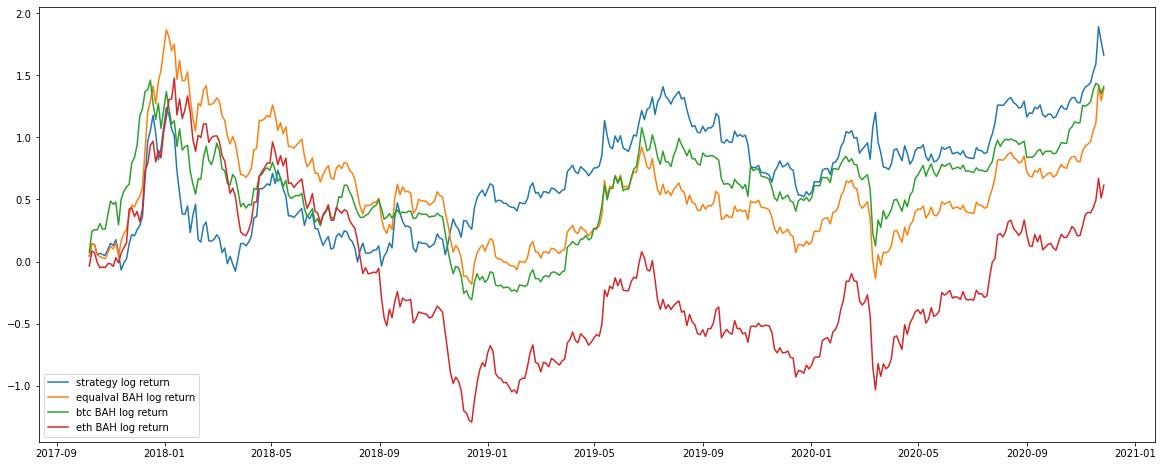

In [244]:
import matplotlib.pyplot as plt
import math

plt.rcParams["figure.figsize"] = (20,8)
stat = stat.dropna(how='any')

plt.plot(stat['date'],stat['log_payoff'].cumsum(), label='strategy log return')
# plt.plot(stat['date'],stat['logret'].apply(lambda x: (math.e)**x).cumprod(), label='BAH simple return')
plt.plot(stat['date'],stat['equalval_logret'].cumsum(), label='equalval BAH log return')
plt.plot(stat['date'],stat['btc_logret'].cumsum(), label='btc BAH log return')
plt.plot(stat['date'],stat['eth_logret'].cumsum(), label='eth BAH log return')
plt.legend()
plt.show()

In [240]:
stat['log_payoff'].cumsum()[-10:]

374    1.278899
375    1.366427
376    1.406328
377    1.420957
378    1.442211
379    1.528092
380    1.593043
381    1.893478
382    1.771204
383    1.663230
Name: log_payoff, dtype: float64

In [234]:
# MULTIVARIATE

symbols = ['btc','eth','xrp']
N = 3

stat = pd.read_csv('./stat.csv')
stat['date'] = stat['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))


def btc_state_map(s):
    if s == 1:
        return 0.189
    if s == 2:
        return 0.198
    if s == 3:
        return -0.276
    if s == 4:
        return 0.333

def eth_state_map(s):
    if s == 1:
        return 0.405
    if s == 2:
        return 0.314
    if s == 3:
        return -0.374
    if s == 4:
        return 0.397

def xrp_state_map(s):
    if s == 1:
        return 0.405
    if s == 2:
        return 0.488
    if s == 3:
        return -0.35
    if s == 4:
        return 0.269



stat['equalval_ret'] = (stat['btc_ret']+stat['eth_ret']+stat['xrp_ret'])/N#+stat['ltc_ret']+stat['link_ret'])/N
stat['equalval_logret'] = stat['equalval_ret'].apply(lambda x: np.log(x))

stat['btc_decision'] = (stat['state'].apply(btc_state_map))
stat['btc_decision_lag1'] = stat['btc_decision'].shift(1)

stat['eth_decision'] = (stat['state'].apply(eth_state_map))
stat['eth_decision_lag1'] = stat['eth_decision'].shift(1)

stat['xrp_decision'] = (stat['state'].apply(xrp_state_map))
stat['xrp_decision_lag1'] = stat['xrp_decision'].shift(1)

# stat['ltc_decision'] = (stat['state'].apply(ltc_state_map))/N
# stat['ltc_decision_lag1'] = stat['ltc_decision'].shift(1)

# stat['link_decision'] = (stat['state'].apply(link_state_map))/N
# stat['link_decision_lag1'] = stat['link_decision'].shift(1)

for s in symbols:
    stat[f'{s}_payoff'] = ((stat[f'{s}_ret']-1) * stat[f'{s}_decision_lag1'])

stat['simple_payoff'] = (stat['btc_payoff']+stat['eth_payoff']+stat['xrp_payoff'])+1#+stat['ltc_payoff']+stat['link_payoff'])+1
stat['log_payoff'] = stat['simple_payoff'].apply(lambda x: np.log(x))


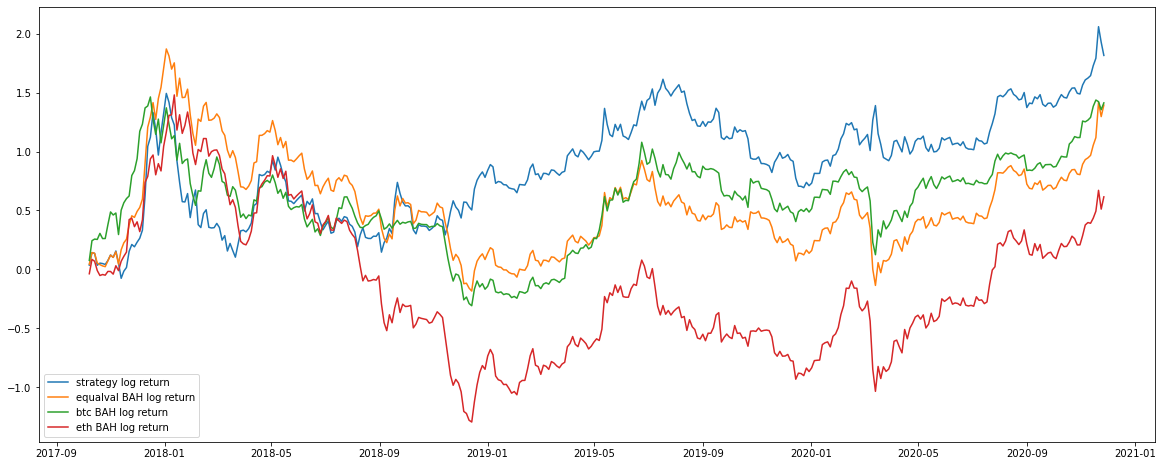

In [235]:
import matplotlib.pyplot as plt
import math

plt.rcParams["figure.figsize"] = (20,8)
stat = stat.dropna(how='any')

plt.plot(stat['date'],stat['log_payoff'].cumsum(), label='strategy log return')
# plt.plot(stat['date'],stat['logret'].apply(lambda x: (math.e)**x).cumprod(), label='BAH simple return')
plt.plot(stat['date'],stat['equalval_logret'].cumsum(), label='equalval BAH log return')
plt.plot(stat['date'],stat['btc_logret'].cumsum(), label='btc BAH log return')
plt.plot(stat['date'],stat['eth_logret'].cumsum(), label='eth BAH log return')
plt.legend()
plt.show()

In [237]:
stat['log_payoff'].cumsum()[-10:]

374    1.487920
375    1.563761
376    1.607437
377    1.622783
378    1.643618
379    1.727734
380    1.791201
381    2.058715
382    1.926671
383    1.814990
Name: log_payoff, dtype: float64